# **Libraries**

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


# **Synthetic Dataset with 5 Classes**

In [105]:
np.random.seed(0)

def generate_class_data(center_x, center_y, size=200, spread=1.5):
    x1 = np.random.randn(size) * spread + center_x
    x2 = np.random.randn(size) * spread + center_y
    return x1, x2

x1_c1, x2_c1 = generate_class_data(3, 4)
x1_c2, x2_c2 = generate_class_data(1, -6)
x1_c3, x2_c3 = generate_class_data(-3, 2)
x1_c4, x2_c4 = generate_class_data(5, 0)
x1_c5, x2_c5 = generate_class_data(-2, -4)

label_c1 = np.full(200, 'C1')
label_c2 = np.full(200, 'C2')
label_c3 = np.full(200, 'C3')
label_c4 = np.full(200, 'C4')
label_c5 = np.full(200, 'C5')

x1 = np.concatenate([x1_c1, x1_c2, x1_c3, x1_c4, x1_c5])
x2 = np.concatenate([x2_c1, x2_c2, x2_c3, x2_c4, x2_c5])
labels = np.concatenate([label_c1, label_c2, label_c3, label_c4, label_c5])

df = pd.DataFrame({'x1': x1, 'x2': x2, 'label': labels})
df.to_csv('five_class_dataset.csv', index=False)
print("CSV file 'five_class_dataset.csv' created.")


CSV file 'five_class_dataset.csv' created.


# **Dataset Visualization**

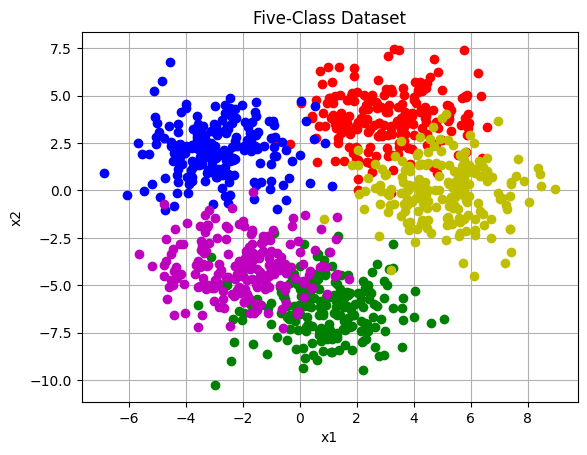

In [106]:
plt.figure()
for i in range(len(df)):
    if df['label'][i] == 'C1':
        plt.plot(df['x1'][i], df['x2'][i], "ro")
    elif df['label'][i] == 'C2':
        plt.plot(df['x1'][i], df['x2'][i], "go")
    elif df['label'][i] == 'C3':
        plt.plot(df['x1'][i], df['x2'][i], "bo")
    elif df['label'][i] == 'C4':
        plt.plot(df['x1'][i], df['x2'][i], "yo")
    else:
        plt.plot(df['x1'][i], df['x2'][i], "mo")

plt.title("Five-Class Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()


# **Features - Labels**


In [107]:
df = pd.read_csv('five_class_dataset.csv')
X = df[['x1', 'x2']].values
Y = df[['label']].values

encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


# **Neural Network Construction with 3 Hidden Layers**

This network is designed for multi-class classification, so the output layer contains as many neurons as there are classes. It features three hidden layers, each with a flexible number of neurons. The learning rate is also adjustable. The first hidden layer feeds into the second, the second into the third, and the third hidden layer connects directly to the output layer. All connection weights are randomly initialized at the start. For the output layer, the softmax activation function is applied, making it well-suited for handling multi-class classification tasks.

In [108]:
class NeuralNetwork(object):
    def __init__(self, h1=32, h2=16, h3=8, lr=0.005):
        inputLayerNeurons = 2
        hiddenLayerNeurons1 = h1
        hiddenLayerNeurons2 = h2
        hiddenLayerNeurons3 = h3
        outputLayerNeurons = 5
        print(f"Initialized with h1={h1}, h2={h2}, h3={h3}, lr={lr}")
        self.learning_rate = lr
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayerNeurons1)
        self.W_H2 = np.random.randn(hiddenLayerNeurons1, hiddenLayerNeurons2)
        self.W_H3 = np.random.randn(hiddenLayerNeurons2, hiddenLayerNeurons3)
        self.W_OH = np.random.randn(hiddenLayerNeurons3, outputLayerNeurons)


    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))


    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        hidden_input1 = np.dot(X, self.W_H1)
        self.hidden_output1 = self.sigmoid(hidden_input1)
        hidden_input2 = np.dot(self.hidden_output1, self.W_H2)
        self.hidden_output2 = self.sigmoid(hidden_input2)
        hidden_input3 = np.dot(self.hidden_output2, self.W_H3)
        self.hidden_output3 = self.sigmoid(hidden_input3)
        output_input = np.dot(self.hidden_output3, self.W_OH)
        pred = self.softmax(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error
        hidden_error3 = output_delta.dot(self.W_OH.T)
        hidden_delta3 = self.learning_rate * hidden_error3 * self.sigmoid(self.hidden_output3, der=True)
        hidden_error2 = hidden_delta3.dot(self.W_H3.T)
        hidden_delta2 = self.learning_rate * hidden_error2 * self.sigmoid(self.hidden_output2, der=True)
        hidden_error1 = hidden_delta2.dot(self.W_H2.T)
        hidden_delta1 = self.learning_rate * hidden_error1 * self.sigmoid(self.hidden_output1, der=True)
        self.W_H1 += X.T.dot(hidden_delta1)
        self.W_H2 += self.hidden_output1.T.dot(hidden_delta2)
        self.W_H3 += self.hidden_output2.T.dot(hidden_delta3)
        self.W_OH += self.hidden_output3.T.dot(output_delta)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

    def predict(self, X):
      probabilities = self.feedForward(X)
      return np.argmax(probabilities, axis=1)


Initialized with h1=32, h2=16, h3=8, lr=0.005


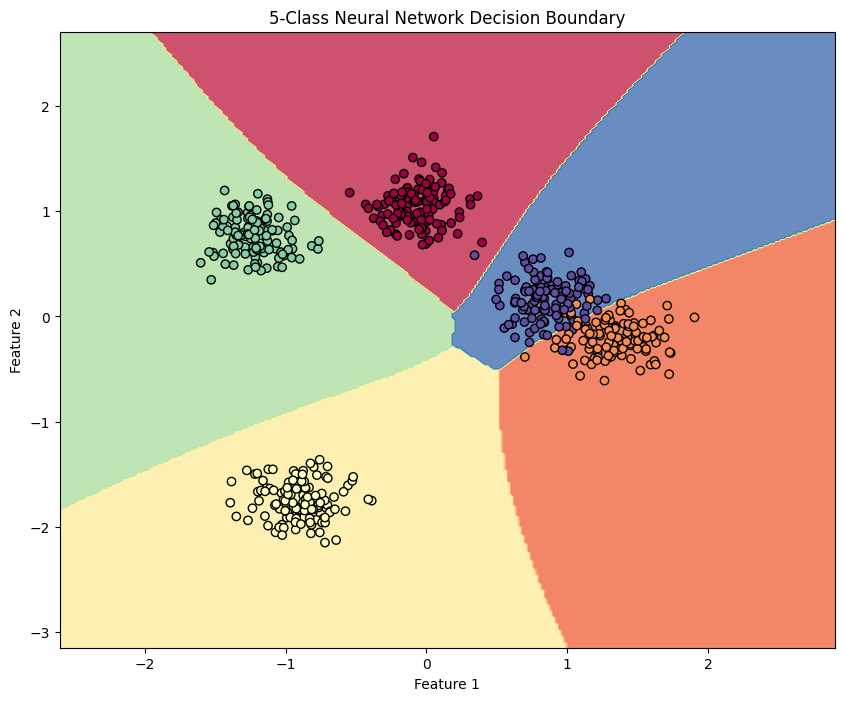

In [109]:
Xb, yb = make_blobs(
    n_samples=600, centers=5, n_features=2,
    random_state=42, cluster_std=1.0
)

Yb_onehot = OneHotEncoder(sparse_output=False).fit_transform(yb.reshape(-1, 1))
Xb = (Xb - Xb.mean(axis=0)) / Xb.std(axis=0)

nn = NeuralNetwork(h1=32, h2=16, h3=8, lr=0.005)
for _ in range(1500):
    nn.train(Xb, Yb_onehot)

h = 0.02
x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
plt.scatter(Xb[:, 0], Xb[:, 1], c=yb, edgecolors='k', cmap=plt.cm.Spectral)
plt.title("5-Class Neural Network Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# A Clean Visualization of the Classificaitons

Initialized with h1=32, h2=16, h3=8, lr=0.005
Final Loss: 0.028591171207799356


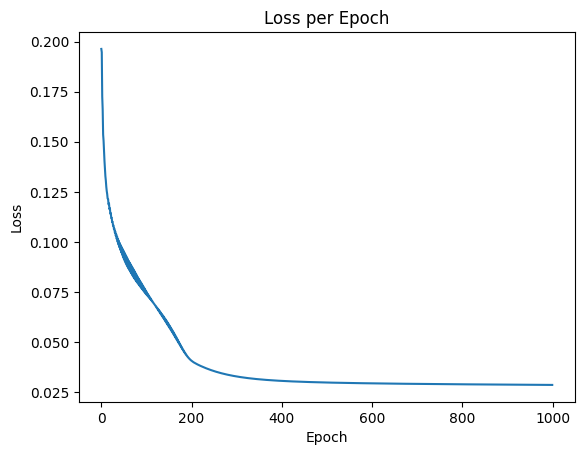

In [110]:
NN = NeuralNetwork()
err = []
for epoch in range(1000):
    NN.train(X_train, Y_train)
    loss = np.mean(np.square(Y_train - NN.feedForward(X_train)))
    err.append(loss)

print(f"Final Loss: {err[-1]}")

plt.plot(err)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Loss Visualization over Epohcs

In [111]:
train_pred = np.argmax(NN.feedForward(X_train), axis=1)
test_pred = np.argmax(NN.feedForward(X_test), axis=1)

Y_train_labels = np.argmax(Y_train, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

print("Training Accuracy:", accuracy_score(Y_train_labels, train_pred))
print("Testing Accuracy:", accuracy_score(Y_test_labels, test_pred))

print("\nClassification Report (Test Data):")
print(classification_report(Y_test_labels, test_pred))


Training Accuracy: 0.90625
Testing Accuracy: 0.875

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        33
           1       0.80      0.92      0.85        48
           2       0.95      0.95      0.95        37
           3       0.94      0.84      0.89        38
           4       0.87      0.75      0.80        44

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.87       200



# Models Predictions & Evaluation

# ROC AUC

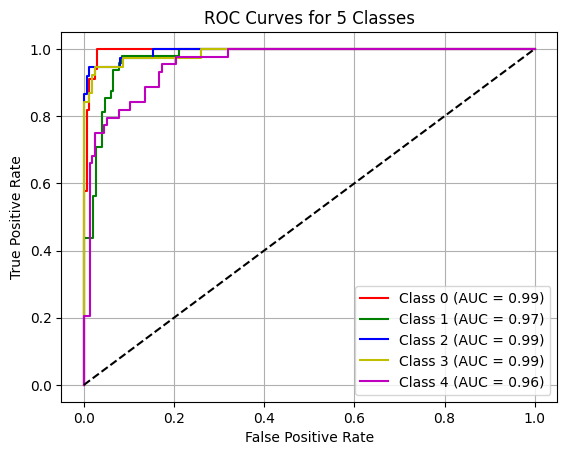

In [112]:
y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], NN.feedForward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ["r", "g", "b", "y", "m"]

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], colors[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves for 5 Classes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# Confusion Matrix

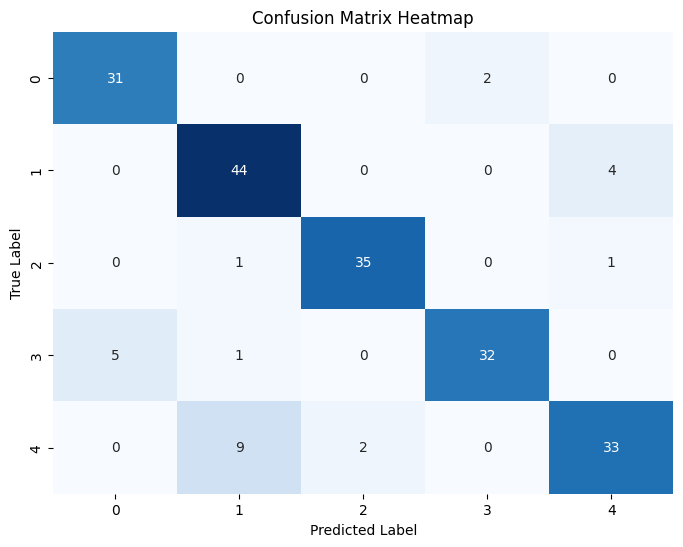

In [113]:
cm = confusion_matrix(Y_test_labels, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [114]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

def train_network_for_epochs(model, X_train, Y_train, epochs=500):
    for _ in range(epochs):
        model.train(X_train, Y_train)


print("Experiment 1: Higher Learning Rate (lr=0.1)")
LR_high = NeuralNetwork(h1=32, h2=16, h3=8, lr=0.1)
train_network_for_epochs(LR_high, Xb, Yb_onehot, epochs=500)
high_test_pred = LR_high.predict(Xb)
print("Accuracy:", accuracy_score(yb, high_test_pred))


print("\nExperiment 2: Default Learning Rate (lr=0.005)")
NN_LR_same = NeuralNetwork(h1=32, h2=16, h3=8, lr=0.005)
train_network_for_epochs(NN_LR_same, Xb, Yb_onehot, epochs=500)
same_test_pred = NN_LR_same.predict(Xb)
print("Accuracy:", accuracy_score(yb, same_test_pred))


print("\nExperiment 3: Lower Learning Rate (lr=0.001)")
LR_low = NeuralNetwork(h1=32, h2=16, h3=8, lr=0.001)
train_network_for_epochs(LR_low, Xb, Yb_onehot, epochs=500)
low_test_pred = LR_low.predict(Xb)
print("Accuracy:", accuracy_score(yb, low_test_pred))


print("\nExperiment 4: More Neurons (h1=52, h2=28, h3=47)")
NN_large = NeuralNetwork(h1=52, h2=28, h3=47, lr=0.005)
train_network_for_epochs(NN_large, Xb, Yb_onehot, epochs=500)
large_test_pred = NN_large.predict(Xb)
print("Accuracy:", accuracy_score(yb, large_test_pred))


print("\nExperiment 5: Fewer Neurons (h1=10, h2=8, h3=6)")
NN_small = NeuralNetwork(h1=10, h2=8, h3=6, lr=0.005)
train_network_for_epochs(NN_small, Xb, Yb_onehot, epochs=500)
small_test_pred = NN_small.predict(Xb)
print("Accuracy:", accuracy_score(yb, small_test_pred))


Experiment 1: Higher Learning Rate (lr=0.1)
Initialized with h1=32, h2=16, h3=8, lr=0.1
Accuracy: 0.38166666666666665

Experiment 2: Default Learning Rate (lr=0.005)
Initialized with h1=32, h2=16, h3=8, lr=0.005
Accuracy: 0.97

Experiment 3: Lower Learning Rate (lr=0.001)
Initialized with h1=32, h2=16, h3=8, lr=0.001
Accuracy: 0.9716666666666667

Experiment 4: More Neurons (h1=52, h2=28, h3=47)
Initialized with h1=52, h2=28, h3=47, lr=0.005
Accuracy: 0.9733333333333334

Experiment 5: Fewer Neurons (h1=10, h2=8, h3=6)
Initialized with h1=10, h2=8, h3=6, lr=0.005
Accuracy: 0.9416666666666667


/tmp/ipython-input-3632970873.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y_pred == i, 0], X[y_pred == i, 1],


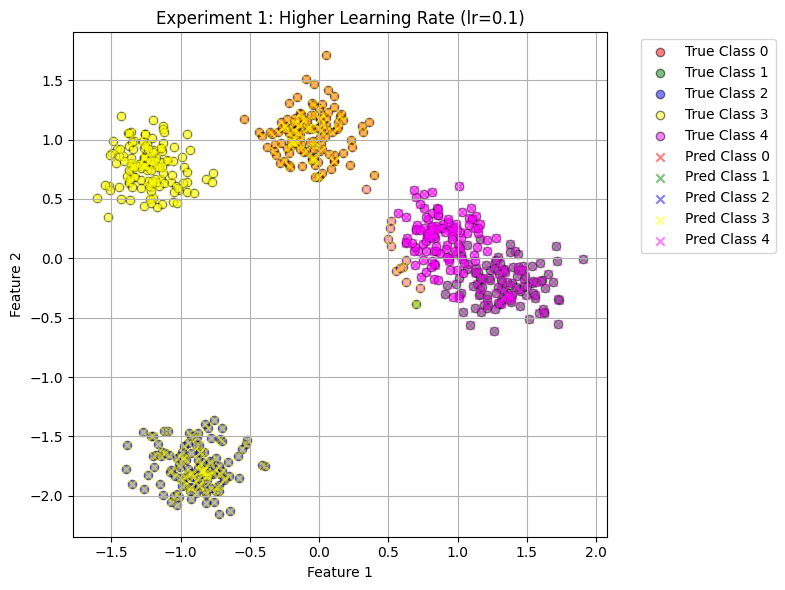

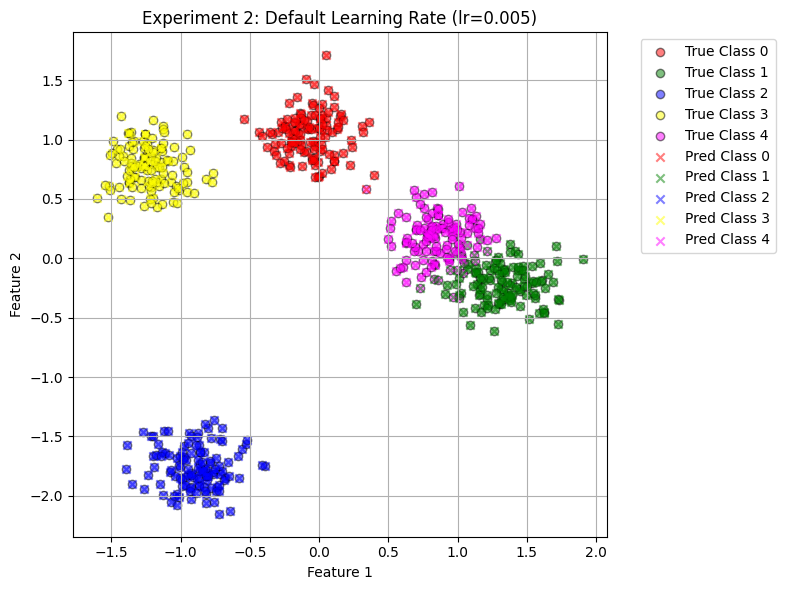

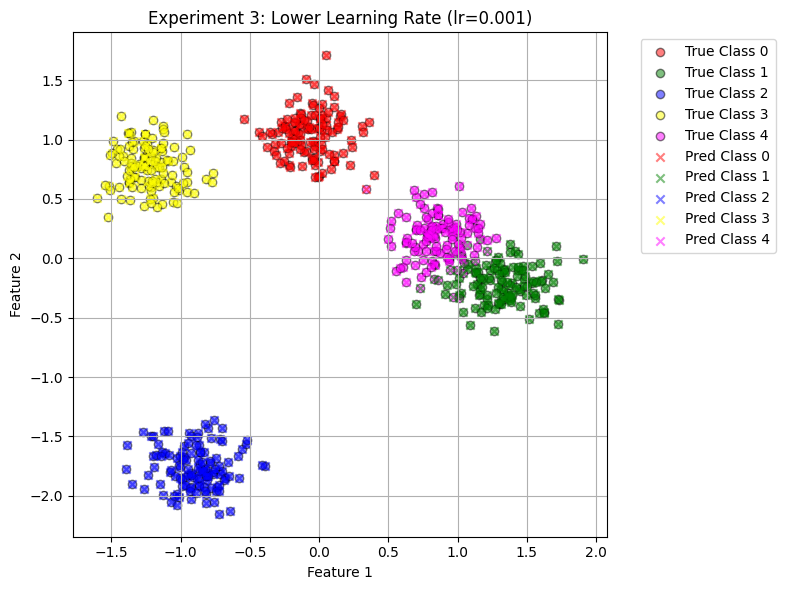

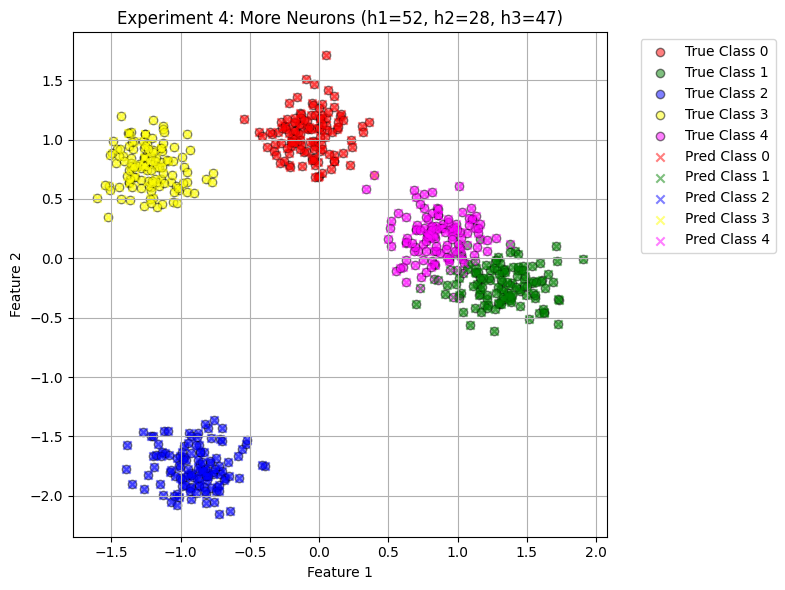

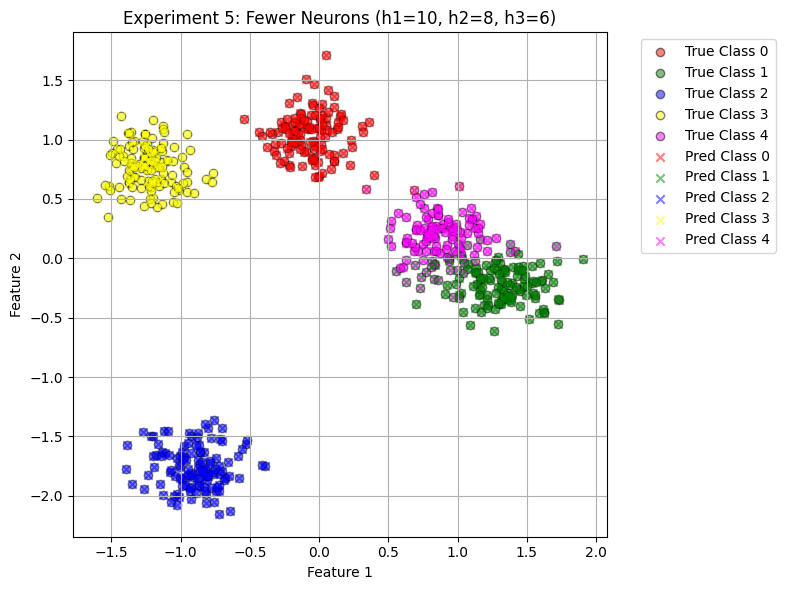

In [115]:
import matplotlib.pyplot as plt

def plot_classifications(X, y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'yellow', 'magenta']


    for i in range(5):
        plt.scatter(X[y_true == i, 0], X[y_true == i, 1],
                    color=colors[i], label=f"True Class {i}",
                    alpha=0.5, marker='o', edgecolors='k')


    for i in range(5):
        plt.scatter(X[y_pred == i, 0], X[y_pred == i, 1],
                    color=colors[i], label=f"Pred Class {i}",
                    alpha=0.5, marker='x', edgecolors='k')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_classifications(Xb, yb, high_test_pred,
                     "Experiment 1: Higher Learning Rate (lr=0.1)")


plot_classifications(Xb, yb, same_test_pred,
                     "Experiment 2: Default Learning Rate (lr=0.005)")


plot_classifications(Xb, yb, low_test_pred,
                     "Experiment 3: Lower Learning Rate (lr=0.001)")


plot_classifications(Xb, yb, large_test_pred,
                     "Experiment 4: More Neurons (h1=52, h2=28, h3=47)")


plot_classifications(Xb, yb, small_test_pred,
                     "Experiment 5: Fewer Neurons (h1=10, h2=8, h3=6)")


# Analysis
The performance of a neural network is highly influenced by both the learning rate and its architecture. By using a fixed random seed, the experiments ensured that the initial weights remained consistent across all trials, allowing for fair comparisons.
When the network was trained with a higher learning rate (0.1), the accuracy plummeted to just 0.38, indicating unstable and ineffective learning. However, with a moderate learning rate (0.005), the same architecture achieved an accuracy of 0.9716, demonstrating stable and efficient training. Reducing the learning rate further to 0.001 resulted in a slight drop in accuracy to 0.97, suggesting slower convergence with minimal improvement.
Increasing the number of neurons in the hidden layers yielded an accuracy of 0.976, implying that beyond a certain point, adding complexity does not necessarily enhance performance. Conversely, reducing the number of neurons led to an accuracy of 0.94, highlighting that insufficient capacity can limit the network’s ability to learn effectively.



# Conclusion

In this project, the multi-class classification model reached highest a ~97% accuracy rate through meticulous hyperparameter tuning, particularly the learning rate. The analysis revealed that both the number of neurons in the hidden layers and the learning rate significantly influenced training accuracy. While a higher learning rate hindered convergence and reduced accuracy, a lower learning rate—along with adjustments to the number of neurons—also affected overall performance. The number of training epochs played a vital role in ensuring the model was adequately trained.
Key challenges involved fine-tuning hyperparameters and understanding how they interact with one another. The main insights highlight the importance of striking a balance between hyperparameters, model complexity, and training duration. Moving forward, potential enhancements could include refining the network architecture and exploring advanced optimization techniques, such as the Adam optimizer and adaptive learning rate strategies.
